# Assessment: Weekly deliverable template - Classification
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns    
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score    
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import fcluster, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 


In [ ]:
# Loading and pre-processing the data as in the week 3 assessment

df = pd.read_csv('wines_SPA.csv')

df = df.drop_duplicates()

# Removing columns I do not want to further use.
df = df.drop(columns=['country', 'acidity'], axis=1)

# Drop missing values and drop duplicates again
df = df.dropna()

# Engineering features

# Price
df['price_log'] = np.log(df['price'])

# Year
# First, convert year into a numeric column, all strings will be NaN
df['year_numeric'] = pd.to_numeric(df['year'], errors='coerce') 
# Add a column to indicate missing values
df['is_nv'] = (df['year_numeric'].isna()).astype(int) 
# Get the median year for imputing
median_year = df['year_numeric'].median()
# impute
df['year_numeric'] = df['year_numeric'].fillna(median_year)
# calculate age
df['age'] = df['year_numeric'].max() + 1 - df['year_numeric']
# calculate log of age
df['age_log'] = np.log(df['age'])


# For categorical variables, only keep those with at least 175 occurrences (10% of all examples), others as 'Other'

# find unique values and their counts in categorical columns 
type_counts = df['type'].value_counts()
winery_counts = df['winery'].value_counts()
wine_counts = df['wine'].value_counts()
region_counts = df['region'].value_counts()

# from each remove the ones with less than 175 occurrences
type_to_keep = type_counts[type_counts >= 175].index
winery_to_keep = winery_counts[winery_counts >= 175].index
wine_to_keep = wine_counts[wine_counts >= 175].index
region_to_keep = region_counts[region_counts >= 175].index

# Create a new type column with only the frequent types, others as 'Other'
df['type_r'] = df['type'].where(df['type'].isin(type_to_keep), 'Other')
df['winery_r'] = df['winery'].where(df['winery'].isin(winery_to_keep), 'Other')
df['wine_r'] = df['wine'].where(df['wine'].isin(wine_to_keep), 'Other')
df['region_r'] = df['region'].where(df['region'].isin(region_to_keep), 'Other')           

# One-hot encode categorical variables leaving out the first category to avoid multicollinearity
type_dummies = pd.get_dummies(df['type_r'], prefix='type', drop_first=True)
winery_dummies = pd.get_dummies(df['winery_r'], prefix='winery', drop_first=True)
wine_dummies = pd.get_dummies(df['wine_r'], prefix='wine', drop_first=True)
region_dummies = pd.get_dummies(df['region_r'], prefix='region', drop_first=True)
# Concatenate the new dummy columns to the original dataframe
df = pd.concat([df, type_dummies, winery_dummies, wine_dummies, region_dummies], axis=1)
# save the dummy column names
type_columns = type_dummies.columns.tolist()    
winery_columns = winery_dummies.columns.tolist()
wine_columns = wine_dummies.columns.tolist()
region_columns = region_dummies.columns.tolist()




**Observations:**  

I only drop 'country' and 'acidity' this time, as they do not have any informational content. I keep add num_reviews, because maybe it is interesting for descriptive clustering. (As discussed in the last assessment, it is not suitable for predicting.) 

Also, I do include 'wine', 'winery' and 'region' this time as it maybe be interesting for clustering. However, I only keeo the values that occur at least in 10% of all examples (175 or more), while summarising the others as 'Others' as I assume that those features wouldn't be stable. (I don't know if the 10% is a good value, but it seems if there are not enough examples, the training is probably not very meaningful. So these 10% are an arbitrary value. I am curious to know if there is a way to determine what a good value would be.) 

### 2. Clustering with results for different values of the parameters (model selection)



Feature matrix shape: (1775, 12)
Silhouette Score for 2 clusters: 0.3009
Silhouette Score for 3 clusters: 0.3383
Silhouette Score for 4 clusters: 0.3982
Silhouette Score for 5 clusters: 0.4232
Silhouette Score for 6 clusters: 0.4207
Silhouette Score for 7 clusters: 0.4472
Silhouette Score for 8 clusters: 0.4280
Silhouette Score for 9 clusters: 0.4023
Silhouette Score for 10 clusters: 0.3933


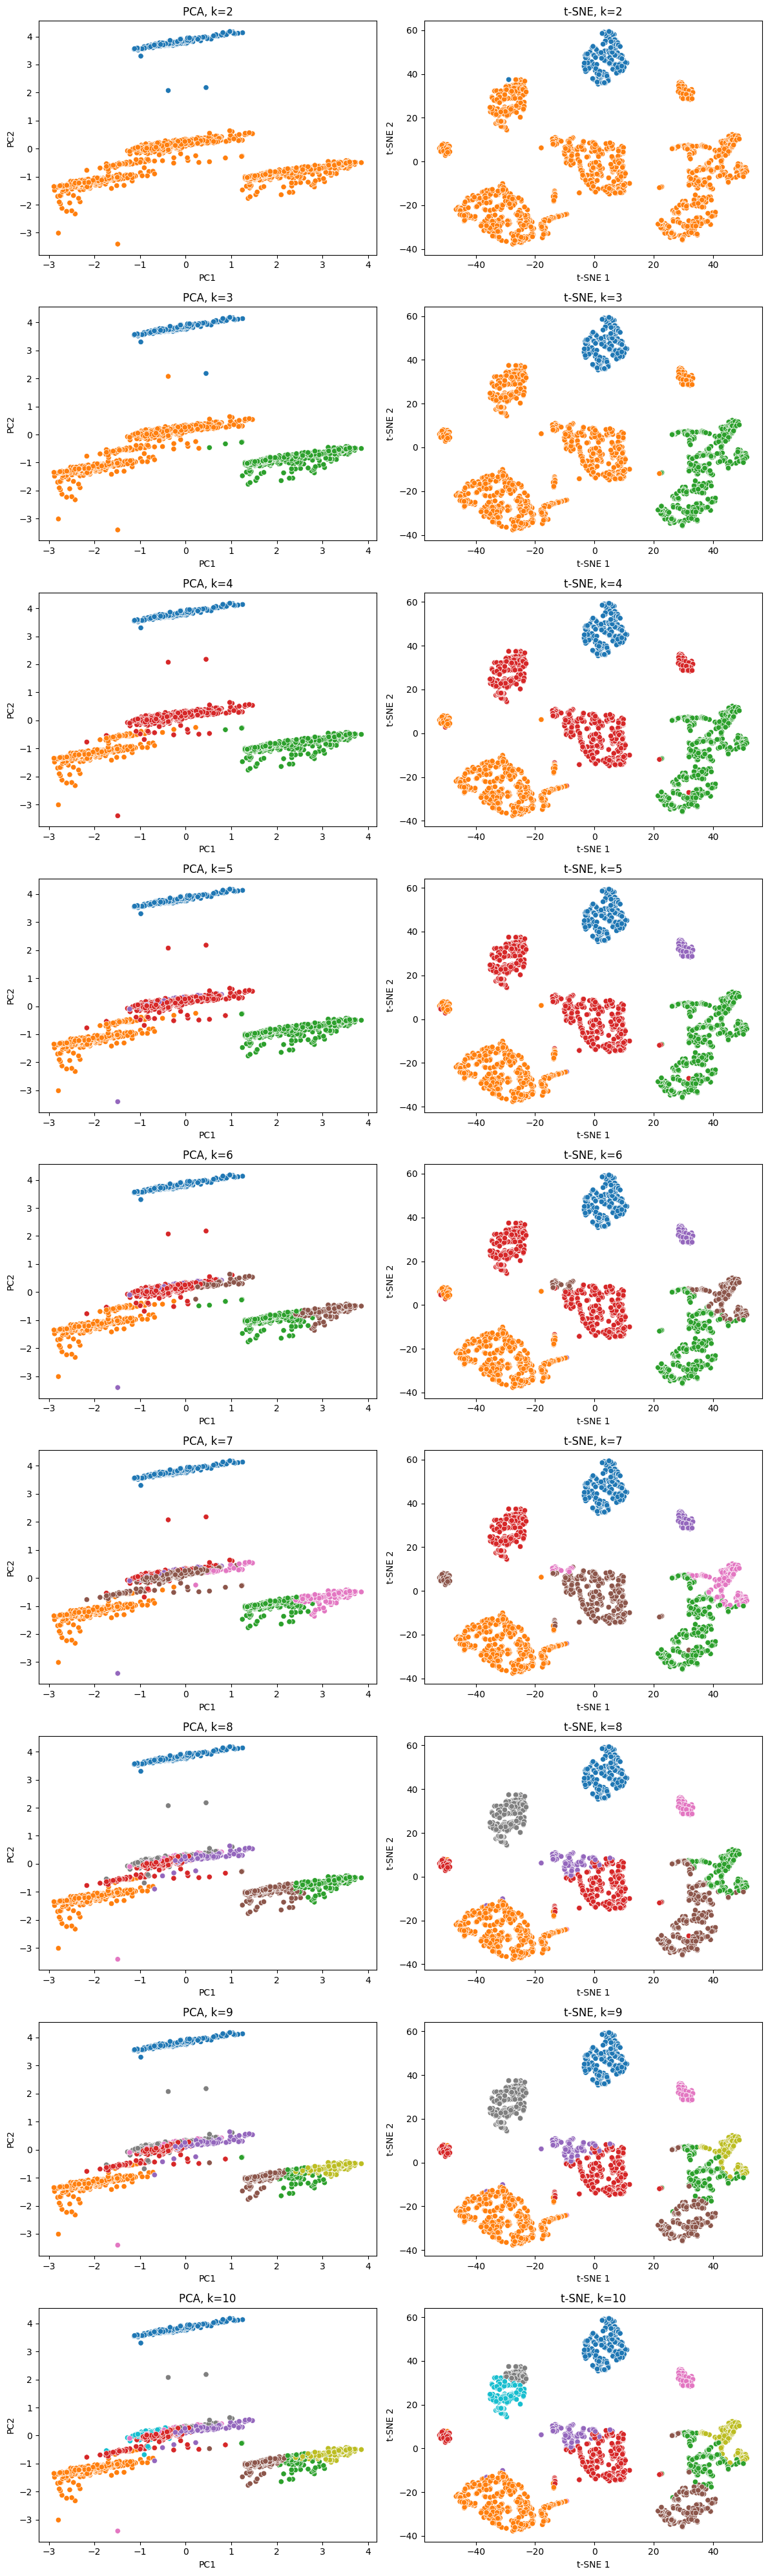

In [65]:
# First I cluster using k-means for a 2-10 clusters and plot the clusters in different colours using PCA for dimensionality reduction.  

# Define feature columns
feature_columns_all = ['rating', 'num_reviews','price_log', 'age_log', 'is_nv'] + type_columns + winery_columns + wine_columns + region_columns


# Scaling the features
X = df[feature_columns_all]
print(f'Feature matrix shape: {X.shape}')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(12, 40))
axes = axes.flatten()

# Function to perform k-means clustering and plot the results
for i, n_clusters in enumerate(range(2, 11)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    labels = kmeans.fit_predict(X_scaled)
    
    # Reduce dimensions using PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Reduce dimensions using t-SNE for visualization
    tsne = TSNE(n_components=2, init='pca', random_state=1)
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot PCA on left column
    ax_pca = axes[2*i]
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='tab10', legend=False, ax=ax_pca)
    ax_pca.set_title(f'PCA, k={n_clusters}')
    ax_pca.set_xlabel('PC1')
    ax_pca.set_ylabel('PC2')
    
    # Plot t-SNE on right column
    ax_tsne = axes[2*i + 1]
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10', legend=False, ax=ax_tsne)
    ax_tsne.set_title(f't-SNE, k={n_clusters}')
    ax_tsne.set_xlabel('t-SNE 1')
    ax_tsne.set_ylabel('t-SNE 2')
    

    # Calculate and print silhouette score
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f'Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}')

plt.tight_layout()

plt.show()


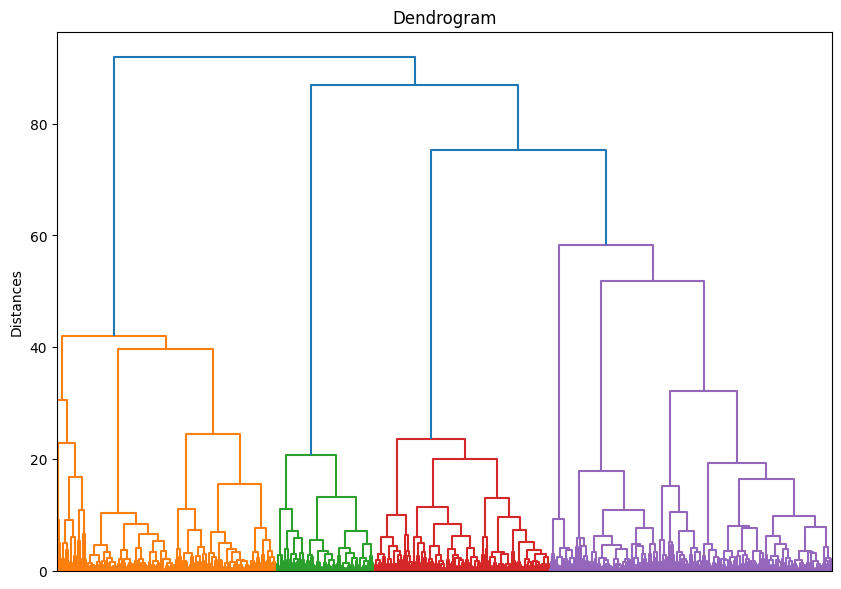

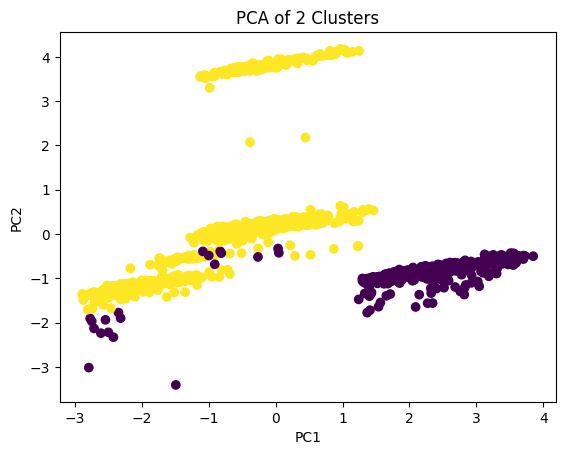

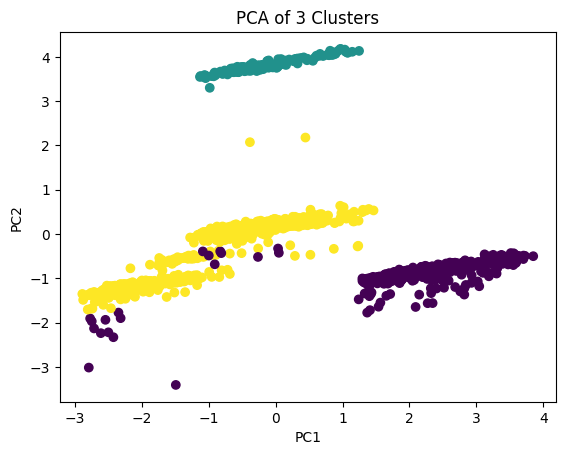

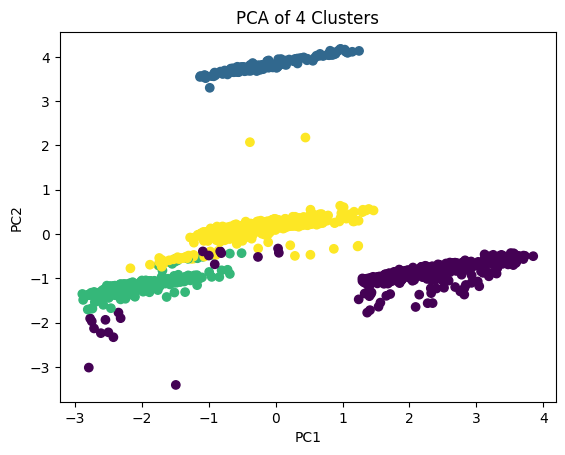

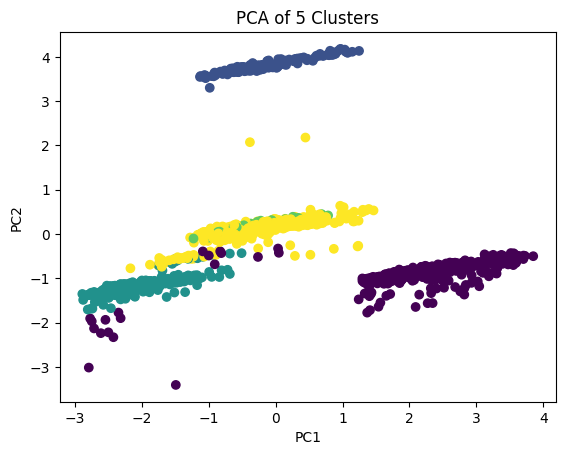

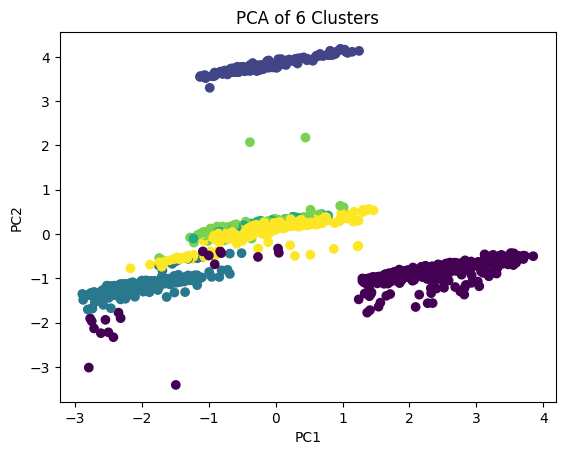

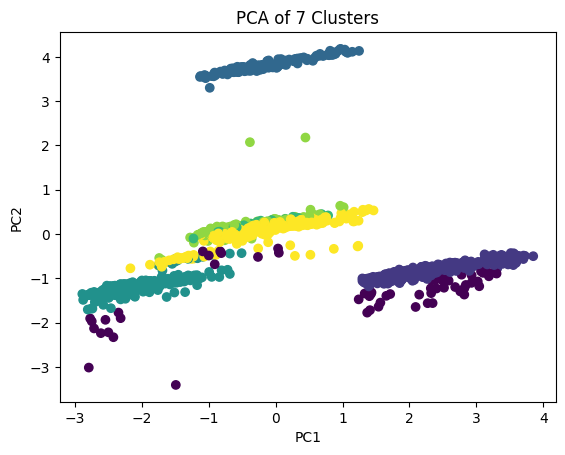

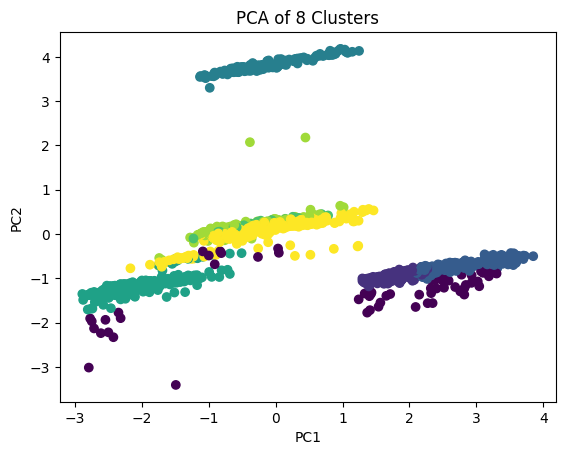

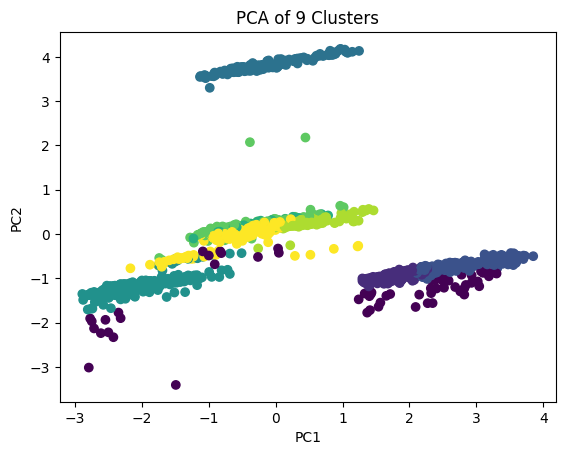

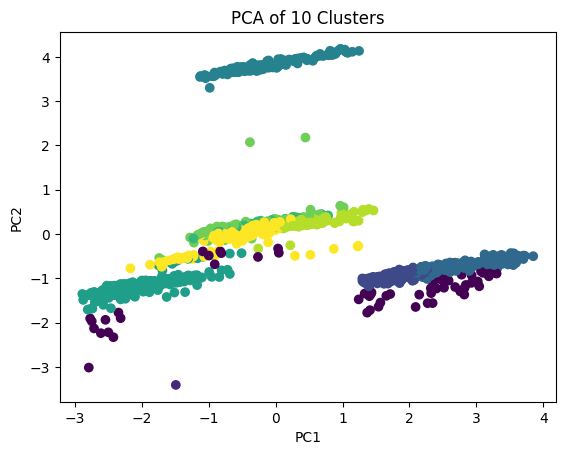

In [ ]:
# Now I try hierarchical clustering with dendrograms

# Create the dendrogram
plt.figure(figsize=(10, 7))
Z = sch.linkage(X_scaled, method='ward')
dendrogram = sch.dendrogram(Z, truncate_mode=None, show_contracted=True)
plt.title('Dendrogram')
plt.xticks([])
plt.xlabel("")
plt.ylabel('Distances')
plt.show()

# Cut the dendrogram to form flat clusters and plot them using PCA for a number of clusters from 2 to 10
for n_clusters in range(2, 11):
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')

    # PCA plot
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
    plt.title(f'PCA of {n_clusters} Clusters')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


**Observations:**  

### 3. Cluster metrics/comparison table on the data + elbow plots


In [ ]:
# ---- Your code here ----

**Observations:**  

### 4. PCA (variance plot + PC scatter plot)


In [ ]:
# ---- Your code here ----

**Observations:**  

### 5. Low-dimensional plot coloured by cluster or rating


In [ ]:
# ---- Your code here ----

**Observations:**  

### 6. Supervised classifier trained + confusion matrix

In [ ]:
# ---- Your code here ----

**Observations:**  

### 7. Comparative discussion (unsupervised vs supervised)

In [ ]:
# ---- Your code here ----

**Observations:**  

### 7. Perform cross validation and statistical techniques (advanced)

In [ ]:
# ---- Your code here ----

**Observations:**  